# k-Nearest Neighbors (Multiclass) Classification from Scratch

## Prepare the Data

### Loading the Data

In [1]:
from sklearn import datasets
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load the wine toy dataset
wine = datasets.load_wine(as_frame = True)

In [2]:
# Take a look at the dataframe
data = wine["frame"]
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
# Print info about the dataframe
print(wine["DESCR"])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

### Selecting Features and Target Variable

In [4]:
# Separate the data and target variable
X = data.iloc[:, : -1].copy()   # We will try to use all features
y = data.iloc[:, -1].copy()

In [5]:
# Check counts of the target classes
y.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

### Normalizing the Data

Since kNN uses the euclidean distance to find the nearest neighbors, we need to normalize the data to make sure all features have the same bearing in the calculations. In this case, we will normalize the data using the min/max scaler.

In [6]:
# Normalize the data using the min/max scaler
X = (X - X.min()) / (X.max() - X.min())

### Splitting Training and Test Set

In [7]:
import numpy as np

# Permute the dataframe to kill any possible ordering used
np.random.seed(0)      # Fix a random seed to allow reproducibility
old_index = data.index
new_index = np.random.permutation(old_index)

X = X.loc[new_index].reset_index(drop = True)
y = y.loc[new_index].reset_index(drop = True)

In [8]:
# Use 80% of the data for training purposes and the remaining 20% for testing purposes
train_test_cut = int(np.floor(len(X)*0.8))

In [9]:
# Create the training set
X_train = X.iloc[: train_test_cut].copy()
y_train = y.iloc[: train_test_cut].copy()

In [10]:
# Create the test set
X_test = X.iloc[train_test_cut :].copy()
y_test = y.iloc[train_test_cut :].copy()

In [11]:
print("The training set has {} samples".format(len(X_train)))
print("The test set has {} samples".format(len(X_test)))

The training set has 142 samples
The test set has 36 samples


In [12]:
# Check the value counts of the target in train and test sets
y_train.value_counts()
y_test.value_counts()

1    56
0    49
2    37
Name: target, dtype: int64

1    15
2    11
0    10
Name: target, dtype: int64

## Implement a k-Nearest Neighbors Classifier from Scratch

### Pseudo Code of the kNN Classification Algorithm

In the following we denote by $\bf x$ the collection of the training samples, by $\bf y$ the corresponding classes, by $\hat {\bf x}$ the collection of the new samples we are trying to predict and with $A$ the collection of unique classes appearing among the samples (in our case $A = \{0, 1, 2\}$).

1. For each $\hat x$ in $\hat {\bf x}$, find the distance between $\hat x$ and each $x$ in $\bf x$. 
2. For each $\hat x$ in $\hat {\bf x}$, use these distances to find its `k` nearest neighbors, i.e., the `k` training samples with minimal distance from $\hat x$ (here the `k` is an integer hyperparameter that is set at the beginning of the algorithm).
3. If we denote by $x_1,\dots, x_k$ these nearest neighbors, then the predicted class for the new sample $\hat x$ is $\text{arg max}_x\big|\big\{\sum_{i=1}^k \textbf{1}_{\{y_i=x\}} : x\in A\big\}\big|$, i.e., the most common class appearing the nearest neighbors.

Note that, if we strictly adhere to the steps above, the kNN classification algorithm could return multiple classes for a single new sample. This happens when there is a tie among the nearest neighbors' classes. Then, in order to obtain an unambiguous classifier, we need to choose a method to break these ties. In our case we'll do the following:    

4. If there is a tie, then filter out all the other classes and predict the class the nearest neighbor belongs to.  

### Coding Step 1

It's important to notice that the vast majority of the calculations are done during Step 1 when computing the distances. Once we obtain these distances, it is fast and easy to find the `k` nearest neighbors (for different values of `k`) and use them to make predictions. For this reason, in order to achieve decent execution times, we implement Step 1 separately.  

In [13]:
def find_distances(X, X_hat, p=2): # We set the same hyperparameter default values used by
                                   # sklearn's instance of kNN Regressor
    """
    Find the distances between the training data and the data we are trying to predict.
    
    :param X: the samples we use to train the model
    :type X: pandas.DataFrame of shape (n_samples, n_features)
    :param X_hat: the samples we want to predict
    :type X_hat: pandas.DataFrame of shape (n_queries, n_features)
    :param p: power parameter which determines which l_p metric is used. It must be in range (1, infty)
    :type p: int, default = 2; this results in the Euclidean metric being used
    
    :return: a dataframe of shape(n_queries, n_samples); the rows are the distances of the samples we want to predict
             from each training sample 
    """     
    
    # Transpose the training data to have the indexes on the columns
    X = X.T
    # Find the distances between each new sample and each training sample
    distances = X.apply(lambda x : (((X_hat - x)**p).sum(axis = 1)) ** (1/p))
    
    return distances

### Coding Step 4

To keep the body of code of the main algorithm more lean, we also separately define the function that takes care of ties.

In [14]:
def break_ties(values):
    """
    Break ties among nearest neighbors classes in case multiple classes have equal counts.
    The tie breaker criterion is distance so the tied class the nearest neighbor belongs to is returned.
    
    :param values: the neighbors' classes
    :type param: pandas.Series of shape (n_neighbors,)
    
    :return: the class that wins the tie
    """
    classes_counts = values.value_counts() 
    tied_classes = classes_counts.loc[classes_counts == classes_counts.max()].index
    relevant_values = values[values.isin(tied_classes)]
    predicted_label = relevant_values.iloc[0]
    
    return predicted_label

### Coding the Rest of the Algorithm

In [15]:
def knn_predict(y, distances, n_neighbors=5): # We set the same hyperparameter default values used by
                                   # sklearn's instance of kNN Regressor
    """
    Run the k-Nearest Neighbors regression algorithm and use it to make predictions.
    
    :param y: the target values of the training data
    :type y: pandas.Series of shape (n_samples,)
    :param distances: the distances between all the training samples and the new samples
    :type distances: pd.DataFrame of shape (n_queries, n_samples)
    :param n_neighbors: the number of neighbors to use in the algorithm
    :type n_neighbors: int, default = 5
    
    :return: output, a dataframe with the following columns
    
                 "nearest_neighbors", contains the indexes of the k-nearest neighbors to each new sample we used
                 
                 "predictions", contains the predicted values
    """
    
    # STEP 2: use the distances to find the nearest neighbors.
    #         The distances will be computed before running this function using the find_distances()
    nearest_neighbors = distances.apply(lambda x : x.sort_values(ascending = True).iloc[:n_neighbors].index, axis = 1)
    
    # STEP 3: use the nearest neighbors to predict the target variable
    predictions = nearest_neighbors.apply(lambda x : y.loc[x].value_counts().idxmax()
                                          if (len(y.loc[x].value_counts()) == 1) or 
                                          (y.loc[x].value_counts().iloc[0] > y.loc[x].value_counts().iloc[1]) 
                                          else break_ties(y.loc[x]))  # STEP 4: break ties if necessary
    
    # Return a dataframe with both the nearest neighbors and the predicted classes
    output = pd.DataFrame({"predictions" : predictions,
                           "nearest_neighbors".format(n_neighbors) : nearest_neighbors
                           })
    
    return output                         

## Evaluating my kNN Classifier

In [16]:
# Initialize a dictionary to evaluate the performance of my kNN Regressor on the test data
my_test_accuracy_scores = dict()
# Initialize the samples we want to predict (in this case, the test data)
X_hat = X_test

# Get the distances between the training samples and the samples we want to predict
distances = find_distances(X_train, X_hat)

# Use my kNN Regressor to predict the test data at different values of n_neighbors
# Evaluate the model using accuracy_score and collect all these values into a dictionary
for k in range(1, 11):  # We use values of k beetween 1 and 10
    knn_output = knn_predict(y_train, distances, k)
    my_test_predictions = knn_output["predictions"]
    my_test_accuracy_scores[k] = (y_test == my_test_predictions).sum() / len(y_test)

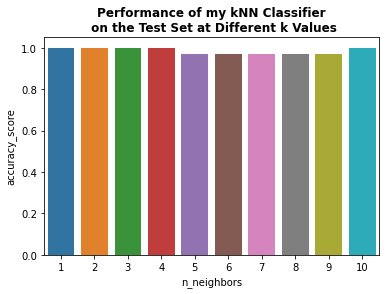

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the errors we obtain
sns.barplot(x = list(my_test_accuracy_scores.keys()), y = list(my_test_accuracy_scores.values()))
plt.xlabel("n_neighbors");
plt.ylabel("accuracy_score");
plt.title("Performance of my kNN Classifier\n on the Test Set at Different k Values", weight = "bold");

## Comparing my Model to sklearn's Implementation of kNN Classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Now do the same thing using the sklearn's kNN Regressor

sklearn_test_errors = dict()

for k in range(1, 11):
    knn_clf = KNeighborsClassifier(n_neighbors = k)
    knn_clf.fit(X_train, y_train)
    sklearn_test_predictions = knn_clf.predict(X_test)  
    sklearn_test_errors[k] = (y_test == sklearn_test_predictions).sum() / len(y_test)

KNeighborsClassifier(n_neighbors=1)

KNeighborsClassifier(n_neighbors=2)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=4)

KNeighborsClassifier()

KNeighborsClassifier(n_neighbors=6)

KNeighborsClassifier(n_neighbors=7)

KNeighborsClassifier(n_neighbors=8)

KNeighborsClassifier(n_neighbors=9)

KNeighborsClassifier(n_neighbors=10)

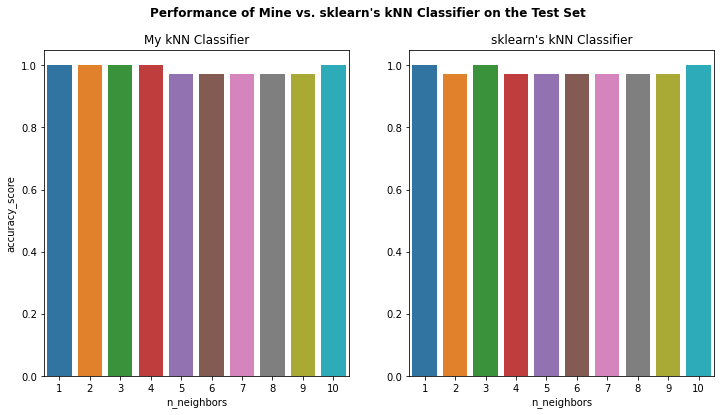

In [19]:
# Compare my kNN Regressor with the one from sklearn by plotting side by side the errors each of them yields 
# on the test data

fig, axs = plt.subplots(1,2, figsize = (12, 6))

_ = sns.barplot(x = list(my_test_accuracy_scores.keys()), y = list(my_test_accuracy_scores.values()), ax = axs[0]);
_ = sns.barplot(x = list(sklearn_test_errors.keys()), y = list(sklearn_test_errors.values()), ax = axs[1]);

_ = axs[0].set_ylabel("accuracy_score")

for ax in axs:
    _ = ax.set_xlabel("n_neighbors")

_ = axs[0].set_title("My kNN Classifier")    
_ = axs[1].set_title("sklearn's kNN Classifier")    

_ = fig.suptitle("Performance of Mine vs. sklearn's kNN Classifier on the Test Set", weight = "bold")

The scores of the two models are identical except for when we use either 2 or 4 neighbors; in this case my model is more accurate than sklearn's. This discrepancy must be a consequence of how each model breaks ties. [Doing some digging](https://stats.stackexchange.com/questions/144718/how-does-scikit-learn-resolve-ties-in-the-knn-classification#:~:text=So%2C%20in%20the%20case%20of%20ties%2C%20the%20answer%20will%20be%20the%20class%20that%20happens%20to%20appear%20first%20in%20the%20set%20of%20neighbors.), one finds out that, in case of a tie, sklearn's kNN classifier predicts the class that appears first in the set of neighbors: this explains why my algorithm performs better.

## Visualize the kNN Algorithm

In [20]:
from sklearn.decomposition import PCA

# Perform dimensionality reduction in order to be able to visualize the samples and the clusters
pca = PCA(n_components = 2) # We use 2 components so that we can use planar plots 
X_train_2D = pd.DataFrame(pca.fit_transform(X_train), index = X_train.index)
X_test_2D = pd.DataFrame(pca.fit_transform(X_test), index = X_test.index)

In [21]:
import time
from IPython.display import clear_output

def display_knn(n_demos = 3, n_neighbors = 3):
    """
    Visualize the k-Nearest Neighbors algorithm by drawing a dynamic scatterplot with the training data, the training data and
    a random new sample, the training data, a random new sample and its nearest neighbors.
    
    :param n_demos: the number of demos to visualize
    :type n_demos: int, default = 3
    :param n_neighbors: the number of nearest neighbors to use
    :type n_neighborss: int, default = 3
    """
    
    # Pick random test samples
    random_samples = X_test_2D.sample(n_demos) 
    
    # Run knn to find all the nearest neighbors of all the test samples
    distances_2D = find_distances(X_train_2D, random_samples)
    knn_output_2D = knn_predict(y_train, distances_2D, n_neighbors)
    samples_nearest_neighbors = knn_output_2D["nearest_neighbors"]
    
    # Loop through the samples
    for i in range(n_demos):
        
        # Fix the current sample
        random_sample = random_samples.iloc[i]
        
        # Find the nearest neighbors to the current sample
        nearest_neighbors_index = samples_nearest_neighbors.iloc[i]
        nearest_neighbors = X_train_2D.loc[nearest_neighbors_index]
        
        # Draw scatterplot with the training data
        fig, ax = plt.subplots(figsize = (8,8))
        ax.scatter(x = X_train_2D.iloc[:, 0], y = X_train_2D.iloc[:, 1],    # Draw the training data in yellow
                   c = "y", label = "training data");
        plt.title("{}-Nearest Neighbors Algorithm".format(n_neighbors), weight = "bold");
        plt.legend(loc = "lower right");
        plt.show();
        time.sleep(3)  # Wait 3 seconds before drawing the next plot
        clear_output(wait = True)  # Clear the current plot before drawing the next one
        
        # Draw scatterplot with the training data and the current test sample
        fig, ax = plt.subplots(figsize = (8,8))
        ax.scatter(x = X_train_2D.iloc[:, 0], y = X_train_2D.iloc[:, 1],    # Draw the training data in yellow
                   c = "y", label = "training data");
        ax.scatter(x = [random_sample[0]], y = [random_sample[1]],    # Draw the new sample in red
                   c = "r", alpha = 1, label = "new sample");
        plt.title("{}-Nearest Neighbors Algorithm".format(n_neighbors), weight = "bold");
        plt.legend(loc = "lower right");
        plt.show();
        time.sleep(3)  # Wait 3 seconds before drawing the next plot
        clear_output(wait = True)  # Clear the current plot before drawing the next one
        
        # Draw scatterplot with the training data, the current test sample and its nearest neighbors
        fig, ax = plt.subplots(figsize = (8,8))
        ax.scatter(x = X_train_2D.iloc[:, 0], y = X_train_2D.iloc[:, 1],    # Draw the training data in yellow
                   c = "y", label = "training data");
        ax.scatter(x = [random_sample[0]], y = [random_sample[1]],    # Draw the new sample in red
                   c = "r", alpha = 1, label = "new sample");
        ax.scatter(x = nearest_neighbors.iloc[:, 0], y = nearest_neighbors.iloc[:, 1],    # Draw the nearest neighbors in blue
                   c = "b", label = "nearest neighbors");
        plt.legend(loc = "lower right")
        plt.title("{}-Nearest Neighbors Algorithm".format(n_neighbors), weight = "bold");
        plt.show();
        time.sleep(3)  # Wait 3 seconds before drawing the next plot  
        clear_output(wait = True)  # Clear the current plot before drawing the next one
        
    return

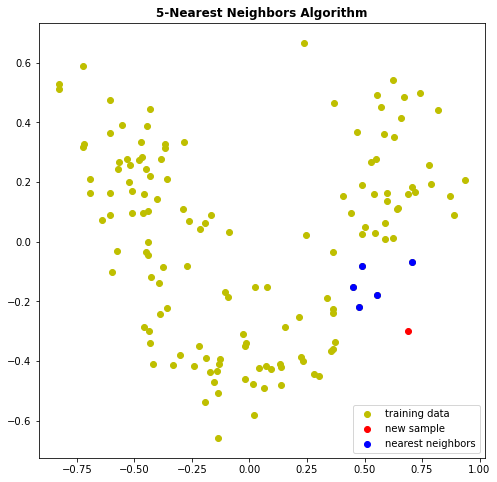

In [22]:
display_knn(n_neighbors = 5)